In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os 
import json

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.models import resnet50

from utils import *


In [6]:
data_path = 'data'
imgs_path = "data/img"
imgs_filename = os.listdir(imgs_path)
len(imgs_filename)

32293

In [7]:
imgs_filename[1]

'COCO_train2014_000000477468.jpg'

In [8]:
id_image = get_imageid(imgs_filename[1])
id_image

'477468'

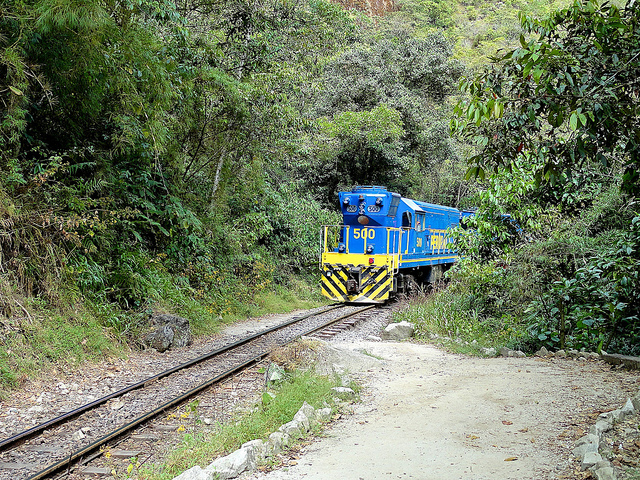

In [9]:
Image.open(os.path.join(imgs_path, imgs_filename[0]))

In [10]:
os.listdir(data_path)

['annotations_trainval2014.zip',
 'person_keypoints_train2014.json',
 'img',
 'instances_train2014.json',
 'captions_val2014.json',
 '.ipynb_checkpoints',
 'annotations_trainval2014',
 'captions_train2014.json',
 'instances_val2014.json',
 'person_keypoints_val2014.json']

In [11]:
captions_json = {f.replace('captions_','').replace('2014.json',''):f for f in os.listdir(data_path) if f.startswith('caption')}
captions_json

{'val': 'captions_val2014.json', 'train': 'captions_train2014.json'}

In [12]:
with open(os.path.join('data', captions_json['train']), 'r') as f:
    data_train = json.load(f)
data_train.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [13]:
data_train['annotations'][0]

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

In [14]:
for img in data_train['annotations']:
    if img['image_id'] == int(id_image):
        print(img['id'], img['caption'].strip('\n'))

478595 Two men in a coffee shop are using laptops. 
478937 A man sitting at a table with a laptop computer.
481964 A man on his phone in front of his laptop at a cafe 
483905 a person sitting at a table with a laptop
823617 A man on a cell phone while sitting at a laptop next to a burger.


In [15]:
annot_by_imageid = get_annot_by_imageid(data_train, unique=True)
len(annot_by_imageid)

82783

In [16]:
annot_by_imageid[int(id_image)]

'Two men in a coffee shop are using laptops. '

In [17]:
imgs_filename = os.listdir(imgs_path)
imgs_filename = [img_tmp for img_tmp in imgs_filename if img_tmp.endswith('jpg')]
print(imgs_filename[0])
len(imgs_filename)

COCO_train2014_000000004322.jpg


32290

In [18]:
imgs = {
    'id':[],
    'filename':imgs_filename,
     'captions': []
}

In [19]:
#sample(test_ds[i]["sentences"], 1)[0]

In [20]:
for img_fl in imgs_filename:
    img_id = get_imageid(img_fl)
    imgs['id'].append(img_id)
    #print(img_id)
    imgs['captions'].append(annot_by_imageid[int(img_id)])
    

In [22]:
df_train = pd.DataFrame(imgs)
df_train.head()

,id,filename,captions
0,4322,COCO_train2014_000000004322.jpg,A train emerging out of the woods on a railroa...
1,477468,COCO_train2014_000000477468.jpg,Two men in a coffee shop are using laptops.
2,249489,COCO_train2014_000000249489.jpg,A man is holding up his skateboard for the cam...
3,432486,COCO_train2014_000000432486.jpg,a room with a lot of decorations and vases in ...
4,225604,COCO_train2014_000000225604.jpg,A plate of food in a nice and neat package.


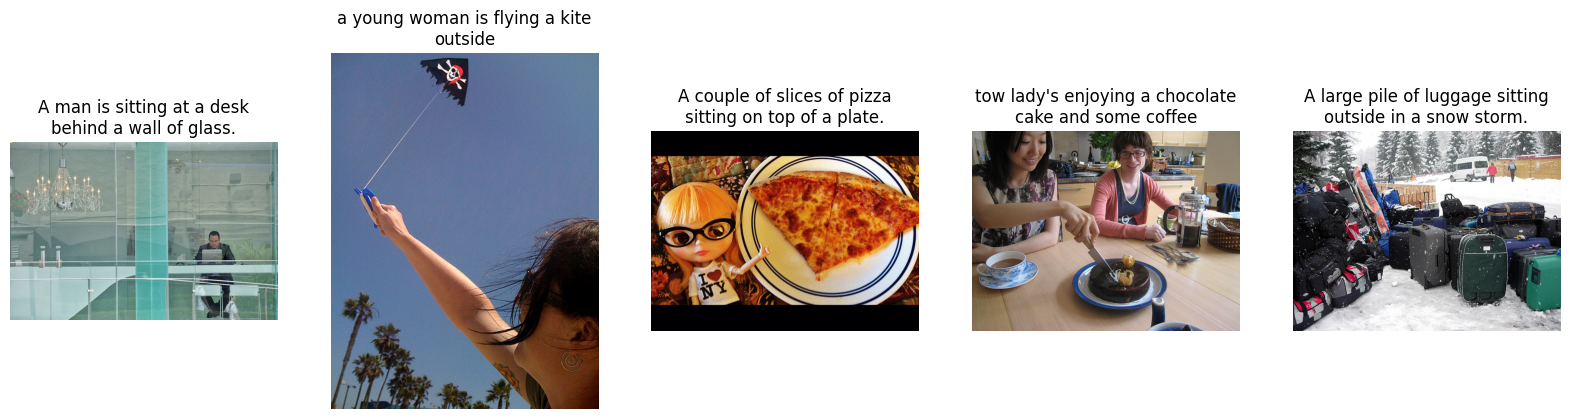

In [25]:
plot_images(df_train, imgs_path)

# Model

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.batch(self.embed(features))
        return features

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*4cE8ZvhN7c_xQRgi.png)

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.drop_prob= 0.2
        self.vocabulary_size = vocab_size
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers,batch_first=True)
        self.dropout = nn.Dropout(self.drop_prob)
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size)
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
    
    def forward(self, features, captions):
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)
        hiddens, c = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
import math

In [14]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 6

# Specify the batch size.
batch_size = 10

In [15]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'
import nltk
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)
sample_caption = []


['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']


In [16]:
from torchtext.vocab import vocab

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
SIDE_SIZE = 224
MEAN = [0.45, 0.45, 0.45]
STD = [0.225, 0.225, 0.225]
CROP_SIZE = 224